<a href="https://www.kaggle.com/code/ewha22sy/esaa-yb-week10-1-transcript?scriptVersionId=208118882" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

### [수비니움 캐글 따라하기] 주택 가격 예측 : Advanced

#### 라이브러리, 데이터 확인하기

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy import stats
from scipy.stats import norm, skew
import warnings
warnings.filterwarnings('ignore') # warnings 무시
%matplotlib inline

# sns Theme 
sns.set_style('darkgrid') 

# 소수점 표현 제한
pd.set_option('display.float_format', lambda x : '{:.3f}'.format(x))

# 디렉토리 내, 사용가능 파일 체크 
from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

house-prices-advanced



In [2]:
# 데이터 읽기
train_df = pd.read_csv('/kaggle/input/house-prices-advanced/train.csv')
test_df = pd.read_csv('/kaggle/input/house-prices-advanced/test.csv')

In [3]:
# 데이터체크
print(train_df.shape, test_df.shape)
train_df.head(5)

(1460, 81) (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


가격 특성 제외 시 80개의 특성을 갖고 있음. 그 외에는 데이터 분석과 상관 없는 Id 특성존재.

In [4]:
# Save the 'Id' comlumn
train_ID = train_df['Id']
test_ID = test_df['Id']

# drop the 'Id' column since it's unnecessary for the prediction process
train_df.drop('Id', axis=1, inplace=True)
test_df.drop('Id', axis=1, inplace=True)

#### Data Processing

##### Outliers
- 데이터의 이상치가 있으므로 이를 어떻게 처리할지 생각해봐야함.

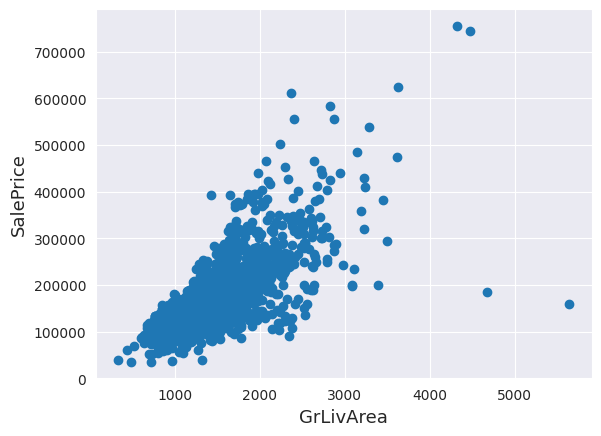

In [5]:
fig, ax = plt.subplots()

ax.scatter(x=train_df['GrLivArea'], y=train_df['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

낮은 SalePrice에서 그래프와 다르게 이상한 2개의 데이터를 확인 가능.

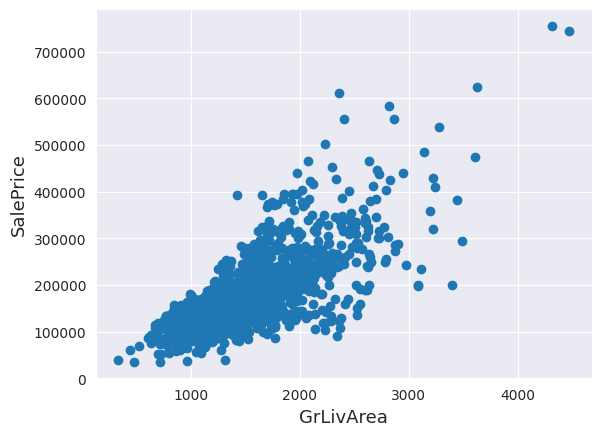

In [6]:
#Deleting outlier
train_df = train_df.drop(train_df[(train_df['GrLivArea']>4000) & (train_df['SalePrice']<300000)].index) 

#Check the Graph again
fig, ax = plt.subplots()
ax.scatter(x=train_df['GrLivArea'], y=train_df['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

이상치 제거는 중요함.    
하지만 일일이 찾아 제거하지 않는 이유
- 훈련 데이터에 이상치가 많을 수 있지만 테스트 데이터에도 이상치가 있을 수 있음
- 오히려 모델에 안 좋은 영향을 미칠 수 있음.

12.024015155682552 0.3995757283645756


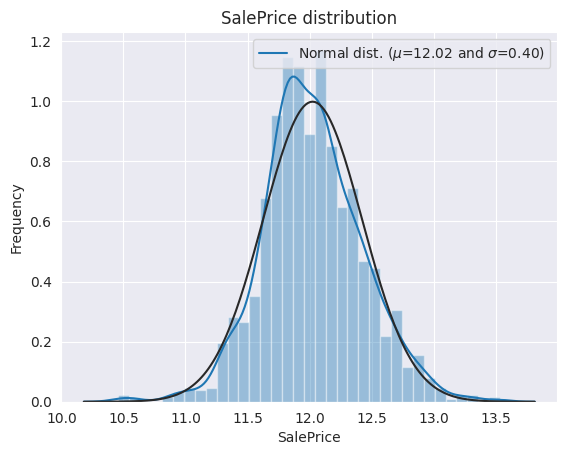

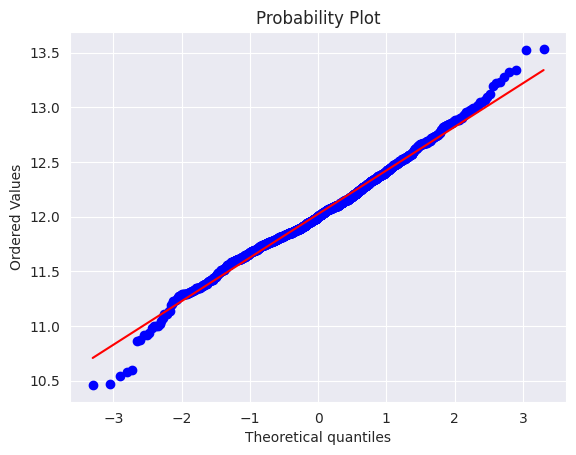

In [7]:
train_df['SalePrice'] = np.log1p(train_df['SalePrice'])

# 위에서와 같은 코드로 똑같이 분포를 확인해봅니다.
sns.distplot(train_df['SalePrice'], fit=norm)
(mu, sigma) = norm.fit(train_df['SalePrice'])
print(mu, sigma)
plt.legend(['Normal dist. ($\mu$={:.2f} and $\sigma$={:.2f})'.format(mu,sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')
fig = plt.figure()
res = stats.probplot(train_df['SalePrice'], plot=plt)
plt.show()

분포가 오른쪽으로 치우침. 선형 모델은 분포가 균형잡힌 상태에 더 용이하므로 Log-transformation of the target variable 진행.

데이터의 정규화를 위해 numpy의 log1p 함수 사용.

2.5663246683992864 0.030669699319462545


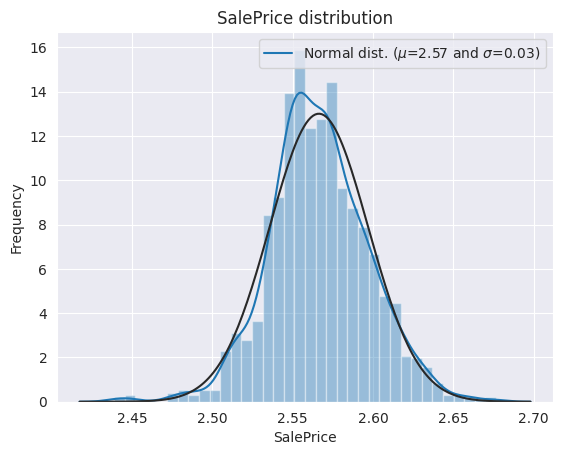

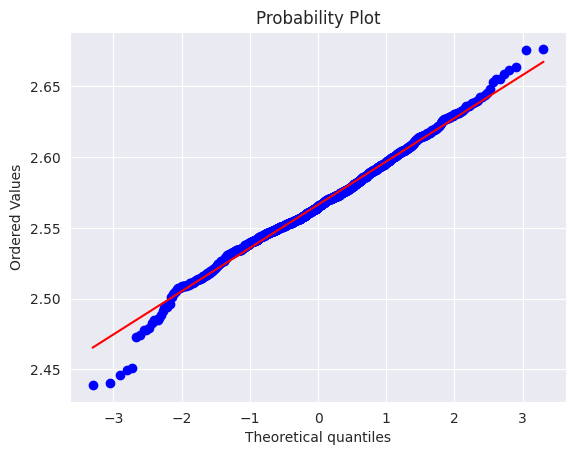

In [8]:
train_df['SalePrice'] = np.log1p(train_df['SalePrice'])

# 위에서와 같은 코드로 똑같이 분포를 확인해봅니다.
sns.distplot(train_df['SalePrice'], fit=norm)
(mu, sigma) = norm.fit(train_df['SalePrice'])
print(mu, sigma)
plt.legend(['Normal dist. ($\mu$={:.2f} and $\sigma$={:.2f})'.format(mu,sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')
fig = plt.figure()
res = stats.probplot(train_df['SalePrice'], plot=plt)
plt.show()

#### Feature Engineering

데이터 하나로 묶기.

In [9]:
ntrain = train_df.shape[0]
ntest = test_df.shape[0]

y_train = train_df.SalePrice.values

all_data = pd.concat((train_df, test_df)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2917, 79)


#### Missing Data

전체 데이터에서 빈 부분 확인

In [10]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]

missing_data = pd.DataFrame({"Missing Ratio" : all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.691
MiscFeature,96.400
Alley,93.212
Fence,80.425
MasVnrType,60.542
FireplaceQu,48.680
LotFrontage,16.661
GarageFinish,5.451
GarageQual,5.451
GarageCond,5.451


##### 데이터 시각화

Text(0.5, 1.0, 'Percent missing data by feature')

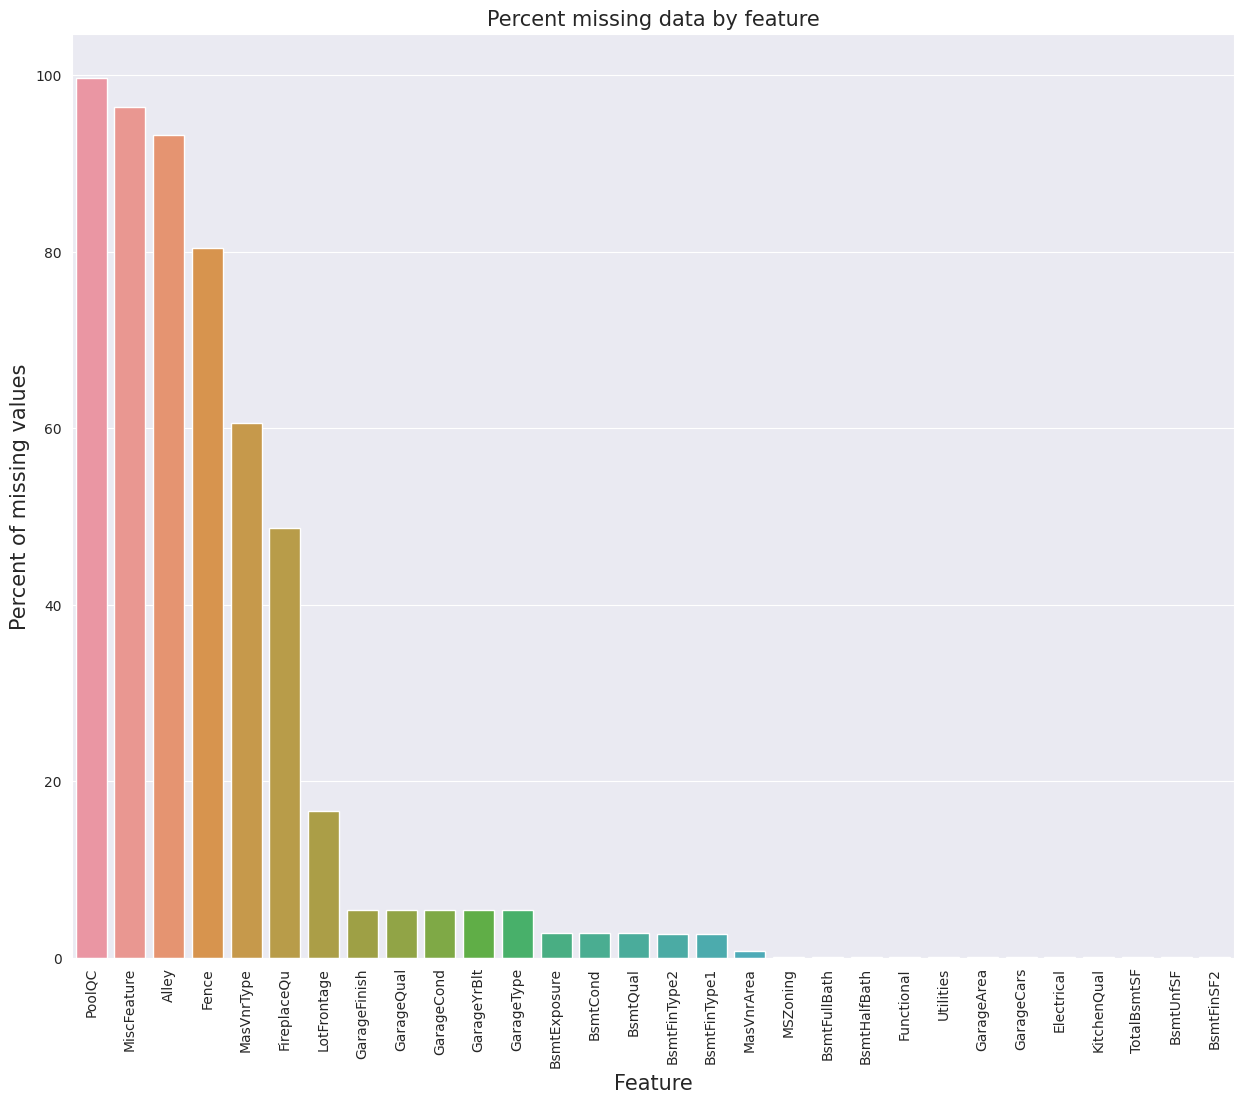

In [11]:
f, ax = plt.subplots(figsize=(15,12))
plt.xticks(rotation='vertical')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Feature', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

##### Data Correlation

heatmap을 이용해 각 요소의 상관관계 시각화     
주시해야할 점: 구하고자 하는 값인 SalePrice와 다른 요소 간의 상관관계

<Axes: >

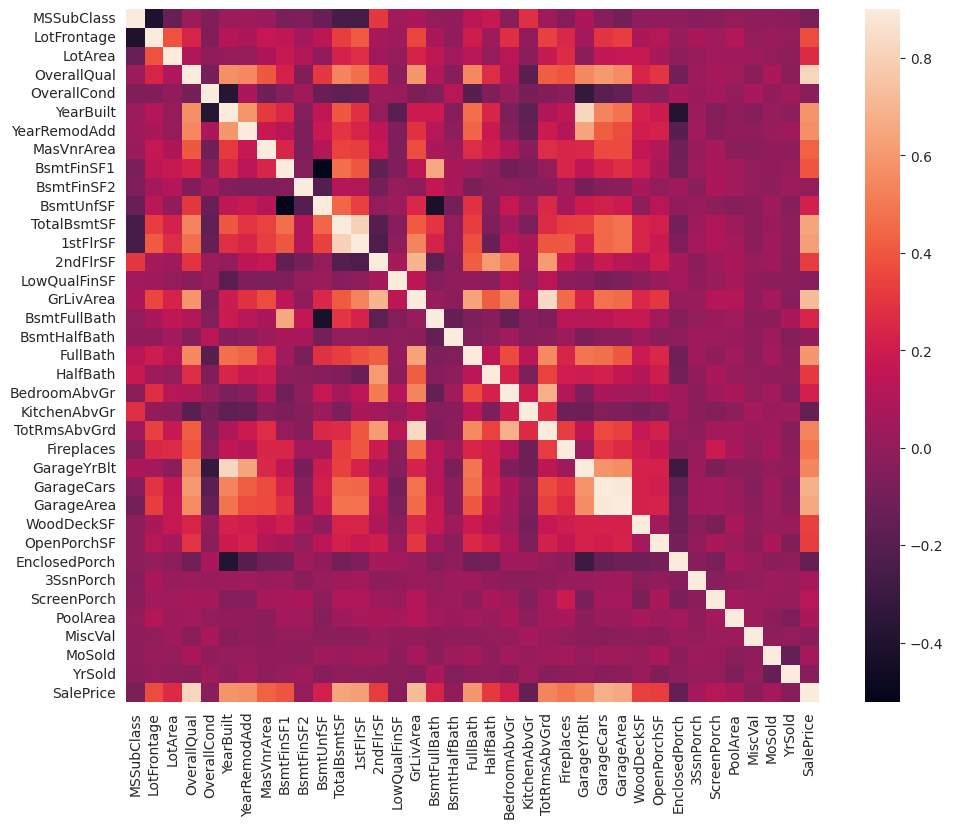

In [12]:
corrmat = train_df.select_dtypes(exclude='object').corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

##### Inputing missing Values

누락된 값 채워넣기     
- PoolQC: NA값은 "No Pool"을 의미. 99%의 값 채우기.

In [13]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")

**MiscFeature** : NA는 "no misc feature".    
이 외에도 Alley, Fence, FireplaceQu도 비슷하게 ~없다 이므로 함께 처리.

In [14]:
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

LotFrantage: 거리와 집의 거리 요소. 이웃들의 거리와 유사한 값을 가질 것.
- 손실된 값들은 이웃들의 중앙값으로 채움.

In [15]:
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x : x.fillna(x.median()))

**GarageType, GarageFinish, GarageQual and GarageCond**: None으로 처리.

In [16]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')

빈 데이터들을 'None' 또는 0으로 처리.

In [17]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

In [18]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

In [19]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

In [20]:
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

**MSZoning(The general zoning classification)** : RL이 최빈값으로 빈 부분은 RL로 채움.

In [21]:
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

**Utilities**: 모든 값이 "AllPub"으로 되어있고 하나가 "NoSeWa", 2개의 NA값이 존재. 예측하는 데에 있어 유용하지 않을 것 같으니 drop.

In [22]:
all_data = all_data.drop(['Utilities'], axis=1)

**Functional** : NA는 typical을 의미.

In [23]:
all_data["Functional"] = all_data["Functional"].fillna("Typ")

**Electrical, KitchenQual, Exterior1st and Exterior2nd, SaleType** : 이 데이터 모두 최빈값으로 채워줌.

In [24]:
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

채우지 못한 데이터 있는지 체

In [25]:
#Check remaining missing values if any 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


#### More features engineering

Transforming some numerical variable that are really categorical    
- 수치형 값들 중 범주형인 특성들 변환

In [26]:
# MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

# Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].apply(str)

# Year and Month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

#### Label Encoding some categorical variables that may contain information in their ordering set

범주형 데이터를 label encoding으로 변환

In [27]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2917, 78)


#### Adding one more important feature
주택 가격에서 중요한 요소 중 하나는 집의 가용 평수.   
따라서 이런 특성을 basement + 1층 + 2층 공간으로 새로운 특성을 하나 만들기.

In [28]:
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

#### Skewed feature

In [29]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# 수치형 데이터에서 skewness 체크
skewed_feats = all_data[numeric_feats].apply(lambda x : skew(x.dropna())).sort_values(ascending=False)

print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.940
PoolArea,17.689
LotArea,13.109
LowQualFinSF,12.085
3SsnPorch,11.372
LandSlope,4.973
KitchenAbvGr,4.301
BsmtFinSF2,4.145
EnclosedPorch,4.002
ScreenPorch,3.945


#### Box Cox Transformation of (highly) skewed features

Box-Cox Transformation은 정규 분포가 아닌 데이터를 정규 분포 형태로 변환하는 방법 중 하나.

In [30]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)

There are 59 skewed numerical features to Box Cox transform


#### Getting dummy categorical features

범주형 데이터를 get_dummies를 이용하여 변환.   
다시 train_df와 test_df로 나누기

In [31]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

train_df = all_data[:ntrain]
test_df = all_data[ntrain:]

(2917, 220)


### Modeling

#### Import Libraries
모델 라이브러리 import

In [32]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

#### Define a cross validation strategy

cross_val_score 함수를 사용.   
하지만 이 함수는 순서를 섞지 않기 때문에 검증의 정도를 높이기 위해 K-fold를 사용하여 검증의 정확도를 더 높인다.

In [33]:
# Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train_df.values)
    rmse = np.sqrt(-cross_val_score(model, train_df.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return (rmse)

#### Base models   
- **LASSO Regression** 이 모델은 이상치에 매우 민감. 따라서 이상치를 좀 더 규제하기 위해 pipeline에 RobustScaler() 메서드를 이용.
- **Elastic Net Regression** 이 모델 또한 이상치를 위해 똑같이 pipeline에 RobustScaler() 메서드 이용.

In [34]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

#### - Kernel Ridge Regression

In [35]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

#### Gradient Boosting Regression
**huber** 손실 함수로 이상치를 관리.   
이 손실함수는 다른 손실함수에 비해 이상치에 대해 민감하지 않음.

In [36]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4,
                                   max_features='sqrt', min_samples_leaf=15, min_samples_split=10,
                                   loss='huber', random_state=5)

#### - XGBoost
각 매개변수, 즉 하이퍼 파라미터 설정은 bayesian optimization을 사용.

In [37]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

#### - LightGBM

In [38]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

#### Base models scores
이 모델들을 교차 검증을 통해 score 구하기.

In [39]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.0098 (0.0006)



In [40]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.0097 (0.0006)



In [41]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.0098 (0.0007)



In [42]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.0091 (0.0007)



In [43]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.0194 (0.0011)



In [44]:
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319

### Stacking models
#### Simplest Stacking approach : Averaging base models

우선 모델들의 성능을 평균하여 사용하는 것으로 시작.  
class를 만들어 캡슐화하고, 코드를 재사용할 수 있게 만들기

In [45]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

#### Averaged base models score

이제 ENet, GBoost, KRR and lasso를 이용해 score를 내본다.

In [46]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print("Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Averaged base models score: 0.0088 (0.0006)



#### Less simple Stacking : Adding a Meta-model
meta model을 추가, base model들의 평균과 이 out-of-folds 예측을 이용하여 meta-model을 훈련.

기본적인 흐름
1. 훈련 데이터를 분리된 데이터셋 train, holdout으로 나눔.
2. train 데이터로 훈련
3. holdout 데이터로 테스트.
4. 3)을 통해 예측값을 구하고, meta model을 통해 그 예측 값으로 모델을 학습.

<br>
<br>
<br>

#### Stacking averaged Models Class
pseudo 코드를 구현했다고 생각하면 됨.

베이스 모델의 예측값을 하나의 특성으로 사용하여 최종 분류를 만든다고 이해하는 것이 가장 좋음.

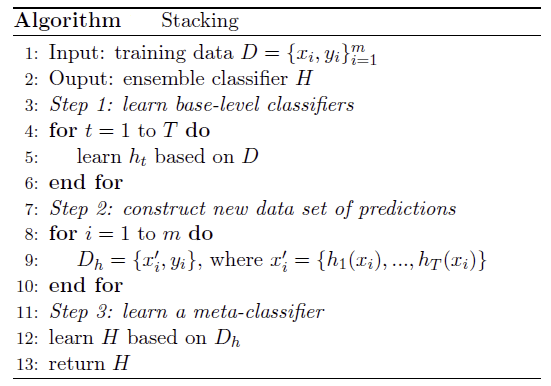

In [47]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # base_models_는 2차원 배열입니다.
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    # 각 모델들의 평균값을 사용합니다.
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

#### Stacking Averaged models Score
성능을 비교하기 위해 같은 모델을 이용하여 score를 만들어보기

In [48]:
stacked_averaged_models = StackingAveragedModels(
    base_models=(ENet, GBoost, KRR),
    meta_model=(lasso)
)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.0087 (0.0005)


### Emsembling StackedRegressor, XGBoost and LightGBM

위에서 만든 XGBoost와 LightBGM을 이용하여 최종 결과를 만들기.

우선 rmsle 함수를 먼저 정의.

In [49]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

### Final Training and Prediction
expm1 함수는 초기에 정규화를 위해 사용한 log1p함수의 역함수.

#### StackedRegressor:

In [50]:
stacked_averaged_models.fit(train_df.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train_df.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test_df.values))
print(rmsle(y_train, stacked_train_pred))

0.005804760334217366


#### XGBoost :

In [51]:
model_xgb.fit(train_df, y_train)
xgb_train_pred = model_xgb.predict(train_df)
xgb_pred = np.expm1(model_xgb.predict(test_df))
print(rmsle(y_train, xgb_train_pred))

0.018134072073644706


#### LightGBM :

In [52]:
model_lgb.fit(train_df, y_train)
lgb_train_pred = model_lgb.predict(train_df)
lgb_pred = np.expm1(model_lgb.predict(test_df.values))
print(rmsle(y_train, lgb_train_pred))

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.23

In [53]:
'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*0.70 +
               xgb_train_pred*0.15 + lgb_train_pred*0.15 ))

RMSLE score on train data:
0.006666744274842865


#### Ensemble prediction :

In [54]:
ensemble = stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15

#### Submission

In [55]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = ensemble
sub.to_csv('submission.csv',index=False)